# Sinkhorn Distence 2D

## Build 2D model

In [1]:
using PyPlot
using PyCall
using LinearAlgebra
ot = pyimport("ot")

include("sinkhorn_1d.jl")

sinkhorn_signal_1D (generic function with 1 method)

In [2]:
function mollifier(X, Y, s, center)
    m = exp.(-s ./ (1 .- (X.-center[1]).^2 .- (Y.-center[2]).^2)); 
    m = m ./ maximum(m)
    return m
end

function sin_func(X, Y, omega1, omega2, s, center)
    f = sin.(2*pi*omega1*(X.-center[1]) .+ 2*pi*omega2*(Y.-center[2]))
    m = mollifier(x, y, s, center)
    return f.*m
end

sin_func (generic function with 1 method)

In [3]:
Nx = 51;
Ny = 51;

h = 0.02;
x = range(0, step=h, length=Nx)
y = range(0, step=h, length=Ny)'

X = zeros(Nx, Ny)
Y = zeros(Nx, Ny)
for i = 1:Ny
    X[:,i] = x
end
for j = 1:Nx
    Y[j,:] = y
end

XX = X[:]
YY = Y[:]
M = zeros(Nx*Ny, Nx*Ny)
for i = 1:Nx*Ny
    for j = 1:Nx*Ny
        M[i,j] = (XX[i] - XX[j]) ^ 2 + (YY[i] - YY[j])^2
    end
end

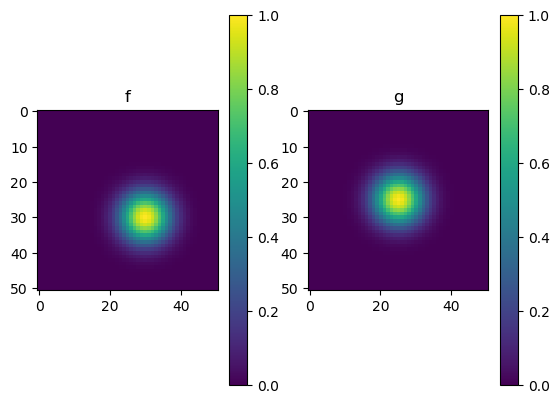

PyObject <matplotlib.colorbar.Colorbar object at 0x104b09e240>

In [4]:
s = 50
f = mollifier(X, Y, s, [0.6,0.6])
g = mollifier(X, Y, s, [0.5,0.5])

figure;
subplot(121); imshow(f); title("f"); colorbar()
subplot(122); imshow(g); title("g"); colorbar()

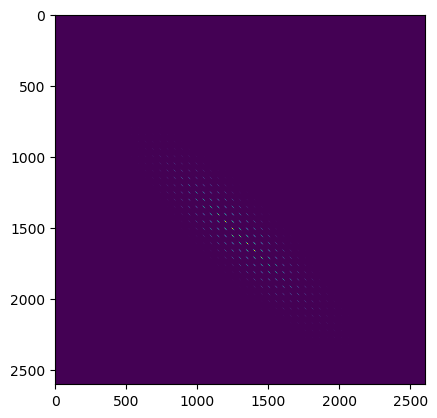

0.024663435616622924

In [5]:
f = f[:]
g = g[:]

# f = abs.(f); g = abs.(g);
# f = f .+ 0.01 * maximum(f);
# g = g .+ 0.01 * maximum(f);


f = f ./ norm(f,1)
g = g ./ norm(g,1)

lambd = 5e-3
G = ot.sinkhorn(f, g, M, lambd, numItermax=500, stopThr=1e-07)
imshow(G)
sum(G.*M)

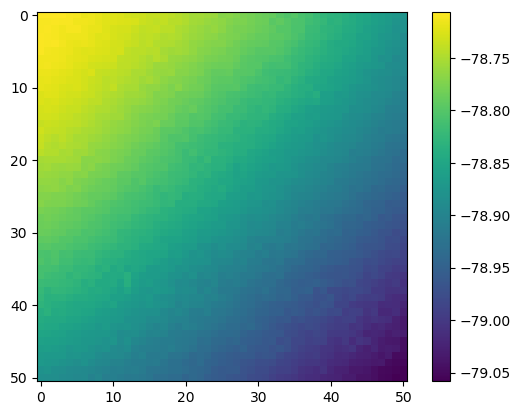

PyObject <matplotlib.colorbar.Colorbar object at 0x104b5a6828>

In [6]:
T = G

n, m = size(T)
T_bar = T[1:n, 1:(m-1)]

L = T .* M
L_bar = L[1:n, 1:(m-1)]

D1 = diagm(T * ones(m))
D2 = diagm(T_bar' * ones(n))
D2 = inv(D2)

H = D1 - T_bar * D2 * T_bar'

ff = -1*L*ones(m) + T_bar * D2 * L_bar' * ones(n)

gg = inv(H) * ff

G = gg - ones(n) * gg' * ones(n)
G = reshape(G, Nx, Ny)
imshow(G); colorbar()

Iteration number: 39
Error: 

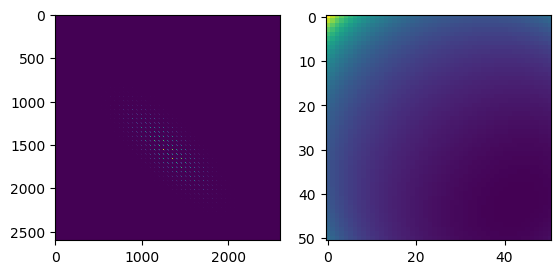

8.382822925503807e-8


PyObject <matplotlib.image.AxesImage object at 0x104b380198>

In [7]:
T, a, d = sinkhorn_basic(f, g, M; lambda=100, numItermax=2000, stopThr=1e-7, verbose=true)
a = reshape(a, (51,51))
figure;
subplot(121); imshow(T)
subplot(122); imshow(a)

In [8]:
function sinkhorn_2d(f, g, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=false)
#     n,m = size(f)
    
    f = f[:]
    g = g[:]
    
#     f = abs.(f); g = abs.(g);
    
    f = f ./ norm(f,1)
    g = g ./ norm(g,1)
    
    T, a, d = sinkhorn_basic(f, g, M; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=verbose)
    
#     a = reshape(a,(n,m))
    return T, a, d
end

sinkhorn_2d (generic function with 1 method)

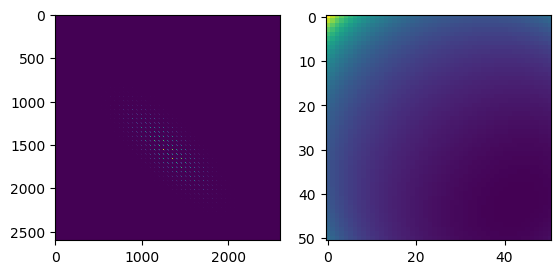

Iteration number: 39
Error: 8.382822925503807e-8


PyObject <matplotlib.image.AxesImage object at 0x105bb2ec50>

In [9]:
s = 50
f = mollifier(X, Y, s, [0.6,0.6])
g = mollifier(X, Y, s, [0.5,0.5])

T, a, d = sinkhorn_2d(f, g, M; lambda=100, numItermax = 2000, stopThr = 1e-7, verbose=true);
a = reshape(a, (51,51))
figure;
subplot(121); imshow(T)
subplot(122); imshow(a)

In [10]:
s = 100
g = mollifier(X, Y, s, [0.5,0.5])
lambda = 5e-3

mis_x = 0.3:0.05:0.7
mis_y = mis_x
n = length(mis_x)
Mis = zeros(n,n);
for i = 1:n
    for j = 1:n
        center = [mis_x[i], mis_y[j]]
        f = mollifier(x, y, s, center)
        T,a,Mis[i,j] = sinkhorn_2d(f, g, M; lambda=100, numItermax = 2000, stopThr = 1e-7, verbose=false);
    end
    println(i/n)
end

0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
1.0


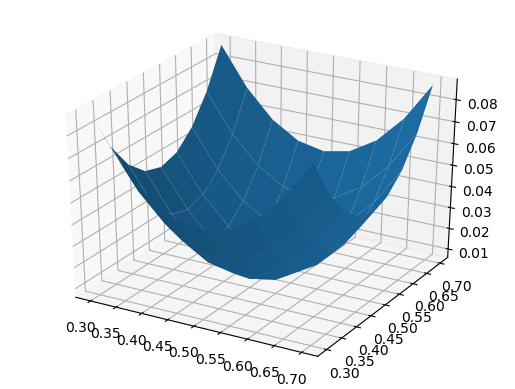

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x105bfa6ba8>

In [11]:
surf(mis_x, mis_y, Mis)

## For signal

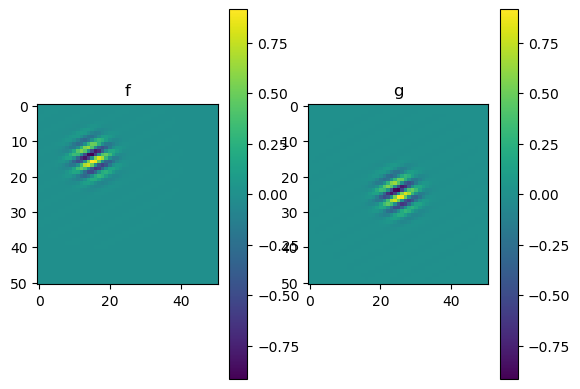

PyObject <matplotlib.colorbar.Colorbar object at 0x12f985630>

In [12]:
s = 100
f = sin_func(X, Y, 10, 5, s, [0.3,0.3])
g = sin_func(X, Y, 10, 5, s, [0.5,0.5])
figure;
subplot(121); imshow(f); title("f"); colorbar()
subplot(122); imshow(g); title("g"); colorbar()

In [13]:
f = f[:]
g = g[:]

N = Nx * Ny
# normalization
fp = zeros(N)
fn = zeros(N)
fp[f .>= 0] = f[f .>= 0]
fn[f .< 0] = f[f .< 0]
fn = abs.(fn)

gp = zeros(N)
gn = zeros(N)
gp[g .>= 0] = g[g .>= 0]
gn[g .< 0] = g[g .< 0]
gn = abs.(gn)

# # for robustness
# fp .+= 0.01*maximum(fp)
# fn .+= 0.01*maximum(fn)
# gp .+= 0.01*maximum(fp)
# gn .+= 0.01*maximum(fn)

fp = fp ./ norm(fp,1)
fn = fn ./ norm(fn,1)
gp = gp ./ norm(gp,1)
gn = gn ./ norm(gn,1);

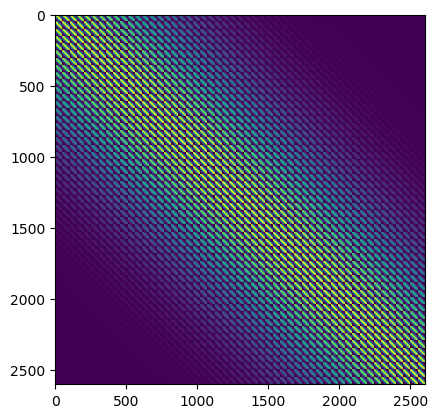

0.01620100161418723

In [14]:
lambd = 1e-1
Gp = ot.sinkhorn(fp, gp, M, lambd, numItermax=500, stopThr=1e-07)
imshow(Gp)
sum(Gp.*M)

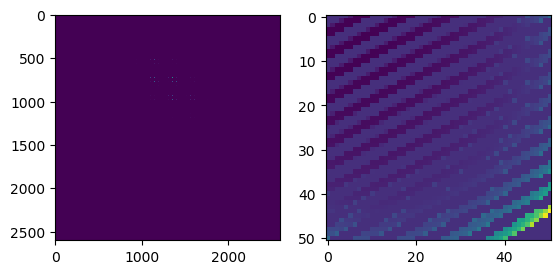

Iteration number: 33
Error: 3.736627121848809e-8


PyObject <matplotlib.image.AxesImage object at 0x105c838278>

In [15]:
T, a, d = sinkhorn_2d(fp, gp, M; lambda=100, numItermax = 2000, stopThr = 1e-7, verbose=true);
a = reshape(a, (51,51))
figure;
subplot(121); imshow(T)
subplot(122); imshow(a)

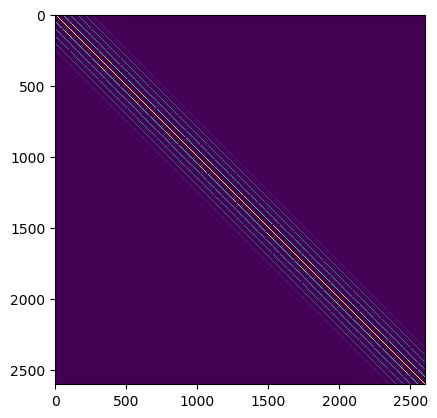

6.68992410040239e-5

In [16]:
lambd = 5e-3
Gn = ot.sinkhorn(fn, gn, M, lambd, numItermax=500, stopThr=1e-07)
imshow(Gn)
sum(Gn.*M)

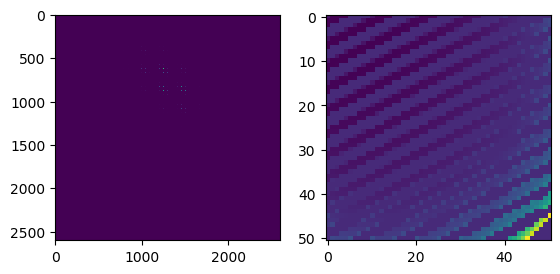

Iteration number: 32
Error: 8.944645212072825e-8


PyObject <matplotlib.image.AxesImage object at 0x105c775dd8>

In [17]:
T, a, d = sinkhorn_2d(fn, gn, M; lambda=100, numItermax = 2000, stopThr = 1e-7, verbose=true);
a = reshape(a, (51,51))
figure;
subplot(121); imshow(T)
subplot(122); imshow(a)

In [18]:
function sinkhorn_signal_2d(f, g, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=false)
    Nx, Ny = size(f)
    N = Nx * Ny
    f = f[:]
    g = g[:]
    # normalization
    fp = zeros(N)
    fn = zeros(N)
    fp[f .>= 0] = f[f .>= 0]
    fn[f .< 0] = f[f .< 0]
    fn = abs.(fn)

    gp = zeros(N)
    gn = zeros(N)
    gp[g .>= 0] = g[g .>= 0]
    gn[g .< 0] = g[g .< 0]
    gn = abs.(gn)

    fp = fp ./ norm(fp,1)
    fn = fn ./ norm(fn,1)
    gp = gp ./ norm(gp,1)
    gn = gn ./ norm(gn,1);
    
    Tp, ap, dp = sinkhorn_basic(fp, gp, M; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=verbose)
    Tn, an, dn = sinkhorn_basic(fn, gn, M; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=verbose)
    
    T = Tp + Tn;
    a = ap - an;
    d = dp + dn;
    return T, a, d
end

sinkhorn_signal_2d (generic function with 1 method)

Iteration number: 24
Error: 8.861314886091602e-8


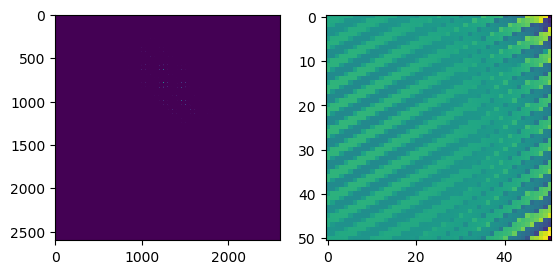

Iteration number: 24
Error: 8.823520340547437e-8


PyObject <matplotlib.image.AxesImage object at 0x105bcd6898>

In [19]:
s = 100
f = sin_func(X, Y, 10, 5, s, [0.5,0.3])
g = sin_func(X, Y, 10, 5, s, [0.5,0.5])

T, a, d = sinkhorn_signal_2d(f, g, M; lambda=100, numItermax = 2000, stopThr = 1e-7, verbose=true);
a = reshape(a, (51,51))
figure;
subplot(121); imshow(T)
subplot(122); imshow(a)

In [20]:
s = 100
g = sin_func(X, Y, 10, 5, s, [0.5,0.5])
lambda = 5e-3

mis_x = 0.3:0.05:0.7
mis_y = mis_x
n = length(mis_x)
Mis = zeros(n,n);
for i = 1:n
    for j = 1:n
        center = [mis_x[i], mis_y[j]]
        f = sin_func(X, Y, 10, 5, s, center)
        T,a, Mis[i,j] = sinkhorn_signal_2d(f, g, M; lambda=100, numItermax = 2000, stopThr = 1e-7, verbose=false);
    end
    println(i/n)
end

0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
1.0


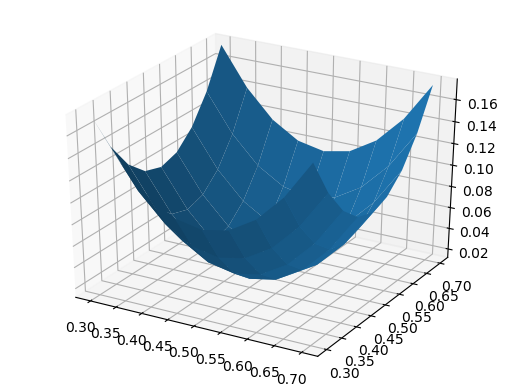

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x105bd73748>

In [21]:
surf(mis_x, mis_y, Mis)